In [1]:
import importlib
import ferbo as fb
importlib.reload(fb)
import numpy as np
%matplotlib widget

Transmon

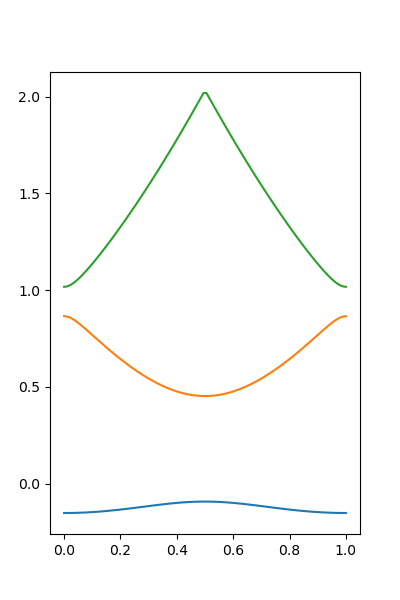

In [42]:
from qutip import charge, tunneling
import matplotlib.pyplot as plt
Nmax = 10
dimension = 2*Nmax + 1
eigvals = 3
Ec, Ej = 1, 2.5
ng_array = np.linspace(0,1, 100)
eigvals_array = np.zeros((len(ng_array),eigvals))
for i, ng in enumerate(ng_array):
    transmon = 4*Ec*(charge(Nmax,-Nmax)-ng)**2 - 0.5*Ej*tunneling(dimension)
    eigvals_array[i], eigvecs = transmon.eigenstates(eigvals= eigvals)

plt.close('all')
fig,ax = plt.subplots(figsize = (4,6))
ax.plot(ng_array,eigvals_array/np.sqrt(8*Ej*Ec))
plt.show()

In [44]:
charge(2,-2, frac=1/2)

Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = True
Qobj data =
[[-1.   0.   0.   0.   0. ]
 [ 0.  -0.5  0.   0.   0. ]
 [ 0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.5  0. ]
 [ 0.   0.   0.   0.   1. ]]

In [49]:
tunneling(5)

Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = True
Qobj data =
[[0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 0.]]

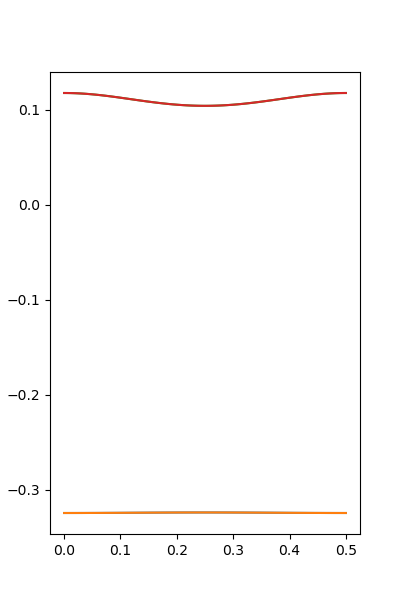

In [55]:
from qutip import charge, tunneling, tensor, sigmaz, qeye
import matplotlib.pyplot as plt
Nmax = 10
dimension = 2*Nmax + 1
eigvals = 4
Ec, Ej = 1, 2.5
ng_array = np.linspace(0,1/2, 100)
eigvals_array = np.zeros((len(ng_array),eigvals))
for i, ng in enumerate(ng_array):
    andreev = 4*Ec*tensor((charge(Nmax,-Nmax, frac=1/2)-ng)**2, qeye(2)) - 0.5*Ej*tensor(tunneling(dimension), sigmaz()) 
    eigvals_array[i], eigvecs = andreev.eigenstates(eigvals= eigvals)

plt.close('all')
fig,ax = plt.subplots(figsize = (4,6))
ax.plot(ng_array,eigvals_array/np.sqrt(8*Ej*Ec))
plt.show()

In [101]:
from qutip import Qobj
import scipy.sparse as sp
def tunneling_minus(N, m = 1):
    diags = [-np.ones(N-m,dtype=int),np.ones(N-m,dtype=int)]
    T = sp.diags(diags,[m,-m],format='csr', dtype=complex)
    return Qobj(T, isherm=True)/1j

In [143]:
def cos_phi(N, phi_ext, m = 1):
    diags = [np.exp(1j*phi_ext/2)*np.ones(N-m,dtype=int),np.exp(-1j*phi_ext/2)*np.ones(N-m,dtype=int)]
    T = sp.diags(diags,[m,-m],format='csr', dtype=complex)
    return Qobj(T, isherm=True)/2

def sin_phi(N, phi_ext, m = 1):
    diags = [np.exp(1j*phi_ext/2)*np.ones(N-m,dtype=int),-np.exp(-1j*phi_ext/2)*np.ones(N-m,dtype=int)]
    T = sp.diags(diags,[m,-m],format='csr', dtype=complex)
    return Qobj(T, isherm=True) /2/1j 

sin_phi(4, np.pi, m = 1)

Quantum object: dims = [[4], [4]], shape = (4, 4), type = oper, isherm = True
Qobj data =
[[0.  0.5 0.  0. ]
 [0.5 0.  0.5 0. ]
 [0.  0.5 0.  0.5]
 [0.  0.  0.5 0. ]]

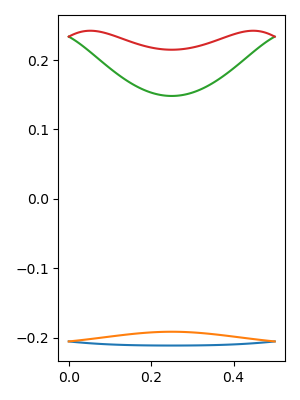

In [156]:
from qutip import charge, tunneling, tensor, sigmaz, sigmay, qeye
import matplotlib.pyplot as plt
Nmax = 20
r = 0.1
phi_ext = 0
dimension = 2*Nmax + 1
eigvals = 4
Ec, Ej = 1,1.5
ng_array = np.linspace(0,1/2, 100)
eigvals_array = np.zeros((len(ng_array),eigvals))
for i, ng in enumerate(ng_array):
    andreev = 4*Ec*tensor((charge(Nmax,-Nmax, frac=1/2)-ng)**2, qeye(2)) + Ej*(tensor(cos_phi(dimension, phi_ext, m = 1), sigmaz()) + r * tensor(sin_phi(dimension, phi_ext, m = 1), sigmay()))
    eigvals_array[i], eigvecs = andreev.eigenstates(eigvals= eigvals)

plt.close('all')
fig,ax = plt.subplots(figsize = (3,4))
ax.plot(ng_array,eigvals_array/np.sqrt(8*Ej*Ec))
fig.tight_layout()
plt.show()

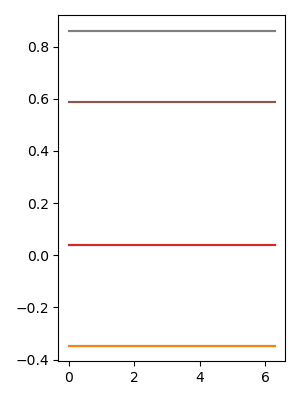

In [149]:
from qutip import charge, tensor, sigmaz, sigmay, qeye, sigmax
import matplotlib.pyplot as plt
Nmax = 10
r = 0.8
ng = 0
dimension = 2*Nmax + 1
eigvals = 8
Ec, Ej = 1,2
phi_array = np.linspace(0,2*np.pi, 100)
eigvals_array = np.zeros((len(phi_array),eigvals))
for i, phi_ext in enumerate(phi_array):
    andreev = 4*Ec*tensor((charge(Nmax,-Nmax, frac=1/2)-ng)**2, qeye(2)) + Ej*(tensor(cos_phi(dimension, phi_ext, m = 1), sigmaz()) + r * tensor(sin_phi(dimension, phi_ext, m = 1), sigmay()))
    eigvals_array[i], eigvecs = andreev.eigenstates(eigvals= eigvals)

plt.close('all')
fig,ax = plt.subplots(figsize = (3,4))
ax.plot(phi_array,eigvals_array/np.sqrt(8*Ej*Ec))
fig.tight_layout()
plt.show()

Tests

  0%|          | 0/100 [00:00<?, ?it/s]

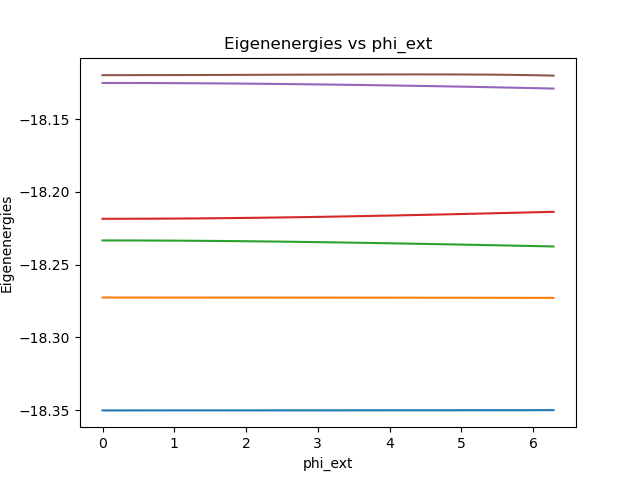

In [153]:
fixed_params = {
    'Ec': 40,
    'El': 0.00001,
    'Delta': 20,
    'r': 0.5,
    'dimension': 100
}

phi_ext_array = np.linspace(0, 2*np.pi, 100)

eigenenergies = fb.eigenenergies_vs_parameter('phi_ext', phi_ext_array, fixed_params)

  0%|          | 0/100 [00:00<?, ?it/s]

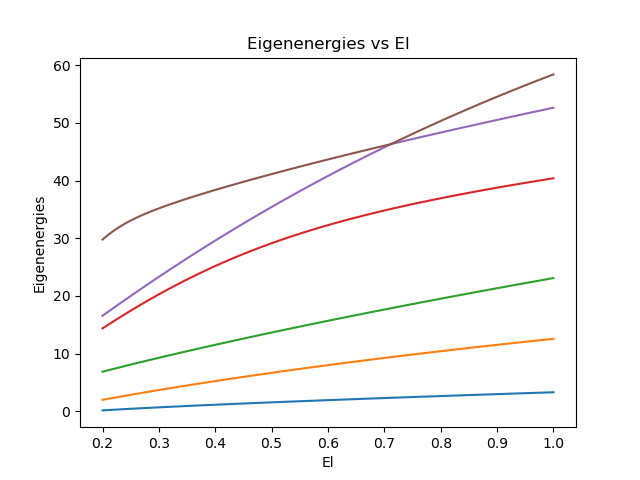

In [3]:
fixed_params = {
    'Ec': 60,
    'Delta': 20,
    'phi_ext': 0,
    'r' : 0.05,
    'dimension': 100
}

El_array = np.linspace(0.2, 1, 100)

eigenenergies = fb.eigenenergies_vs_parameter('El', El_array, fixed_params)

  0%|          | 0/100 [00:00<?, ?it/s]

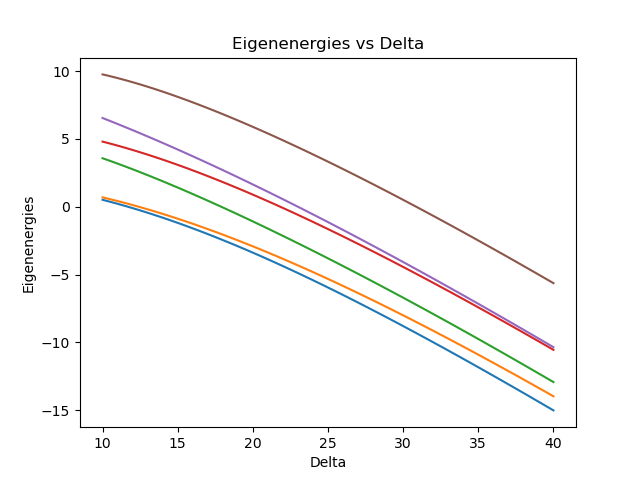

In [4]:
fixed_params = {
    'Ec': 40,
    'El': 0.05,
    'phi_ext': 0,
    'r' : 0.05,
    'dimension': 100
}

Delta_array = np.linspace(10, 40, 100)

eigenenergies = fb.eigenenergies_vs_parameter('Delta', Delta_array, fixed_params)

  0%|          | 0/100 [00:00<?, ?it/s]

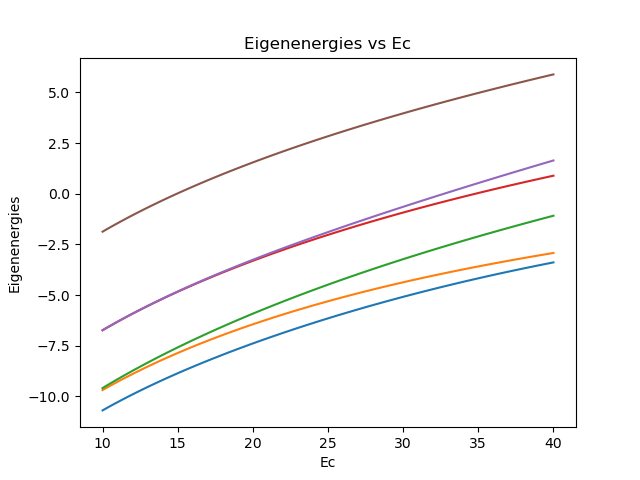

In [5]:
fixed_params = {
    'El': 0.05,
    'Delta' : 20,
    'phi_ext': 0,
    'r' : 0.05,
    'dimension': 100
}

Ec_array = np.linspace(10, 40, 100)

eigenenergies = fb.eigenenergies_vs_parameter('Ec', Ec_array, fixed_params)

  0%|          | 0/100 [00:00<?, ?it/s]

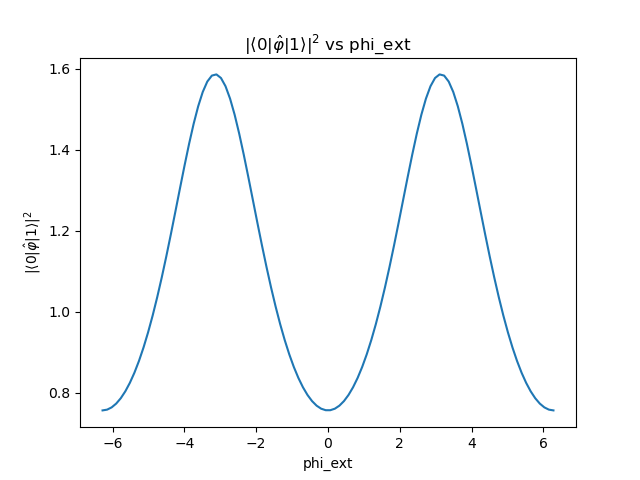

  0%|          | 0/100 [00:00<?, ?it/s]

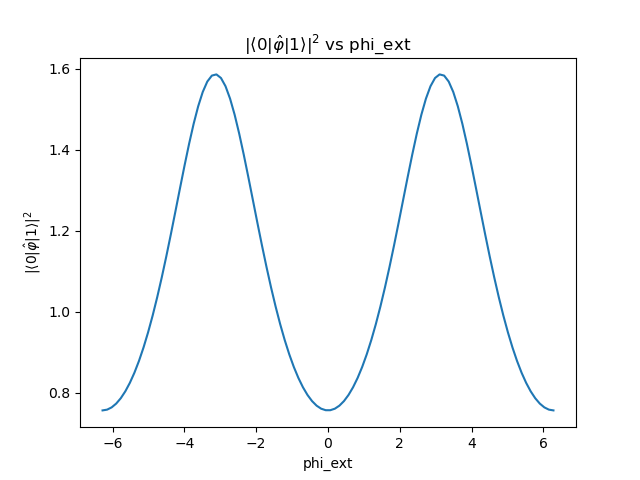

In [6]:
fixed_params = {
    'Ec': 50,
    'El': 0.05,
    'Delta': 20,
    'r': 0.05,
    'dimension': 100
}

phi_ext_array = np.linspace(-2*np.pi, 2*np.pi, 100)

matrix_elements, eigenenergies = fb.matrix_elements_vs_parameter(parameter_name='phi_ext', parameter_values=phi_ext_array, operator_name='phase', state_i=0, state_j=1, fixed_params=fixed_params)

  0%|          | 0/100 [00:00<?, ?it/s]

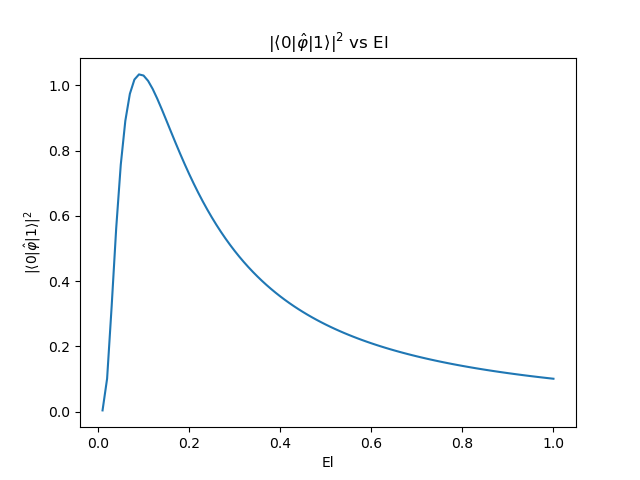

  0%|          | 0/100 [00:00<?, ?it/s]

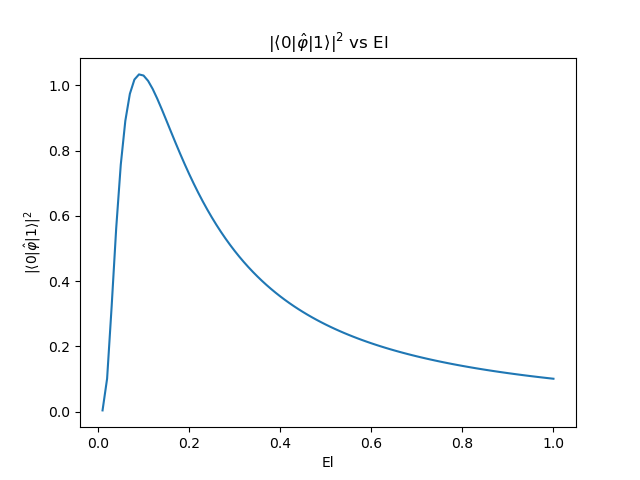

In [7]:
fixed_params = {
    'Ec': 50,
    'Delta': 20,
    'r': 0.05,
    'phi_ext': 0,
    'dimension': 100
}

El_array = np.linspace(0.01, 1, 100)

matrix_elements, eigenenergies = fb.matrix_elements_vs_parameter(parameter_name='El', parameter_values=El_array, operator_name='phase', state_i=0, state_j=1, fixed_params=fixed_params)

  0%|          | 0/100 [00:00<?, ?it/s]

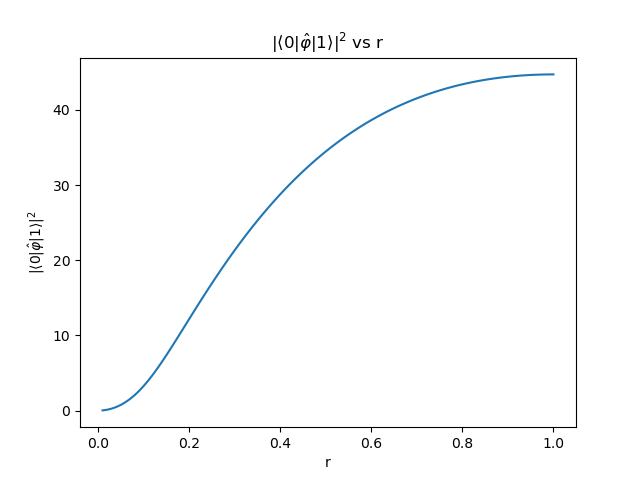

  0%|          | 0/100 [00:00<?, ?it/s]

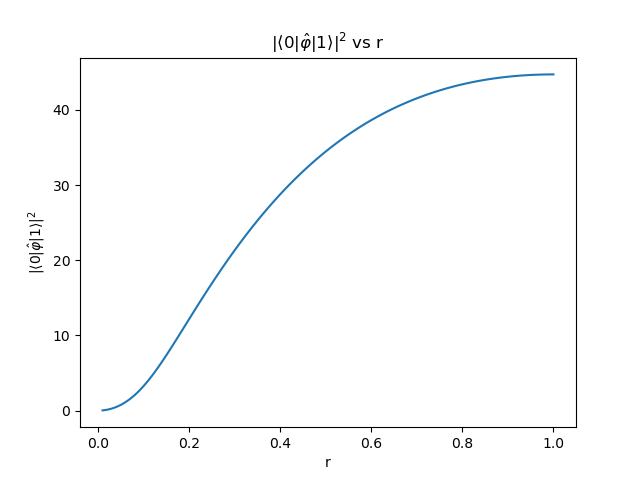

In [8]:
fixed_params = {
    'Ec': 50,
    'El': 0.05,
    'Delta': 20,
    'phi_ext': 0,
    'dimension': 100
}

r_array = np.linspace(0, 1, 100)

matrix_elements, eigenenergies = fb.matrix_elements_vs_parameter(parameter_name='r', parameter_values=El_array, operator_name='phase', state_i=0, state_j=1, fixed_params=fixed_params)